<a id='head'></a>

# Определение возраста покупателей

## Оглавление
 
- [**Введение**](#intro)
    - [Входные данные](#input_data)
    - [Ход исследования](#progress)
    
- [**1. Исследовательский анализ данных**](#part_1)
    - [Выводы](#part_1_conclusions)

- [**2. Обучение модели**](#part_2)
    - [2.1 Код обучения модели](#part_2_1)
    - [2.2 Результат вывода на экран](#part_2_2)

- [**3. Анализ обученной модели**](#part_3)

- [Чек лист](#check_list)

<a id='intro'></a>
# Введение [▴](#head)

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

<a id='input_data'></a>
## Входные данные [▴](#head)

Данные взяты с сайта [**ChaLearn Looking at People**](http://chalearnlap.cvc.uab.es/dataset/26/description/). Они находятся в папке `/datasets/faces/`.

В нашем распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

<a id='progress'></a>
## Ход исследования [▴](#head)

Необходимо:

- Провести исследовательский анализ данных
    - посмотреть размер выборки
    - изучить распределение возраста в выборке
    - вывести на экран 10-15 фотографий
- Обучить нейронную сеть на GPU с значением `MAE` не выше `8`
- Сделать выводы

<a id='part_1'></a>
# 1. Исследовательский анализ данных [▴](#head)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
print(labels.head())
print('_' * 70)
print(labels.info())
print('_' * 70)
print(labels.describe())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
______________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
______________________________________________________________________
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


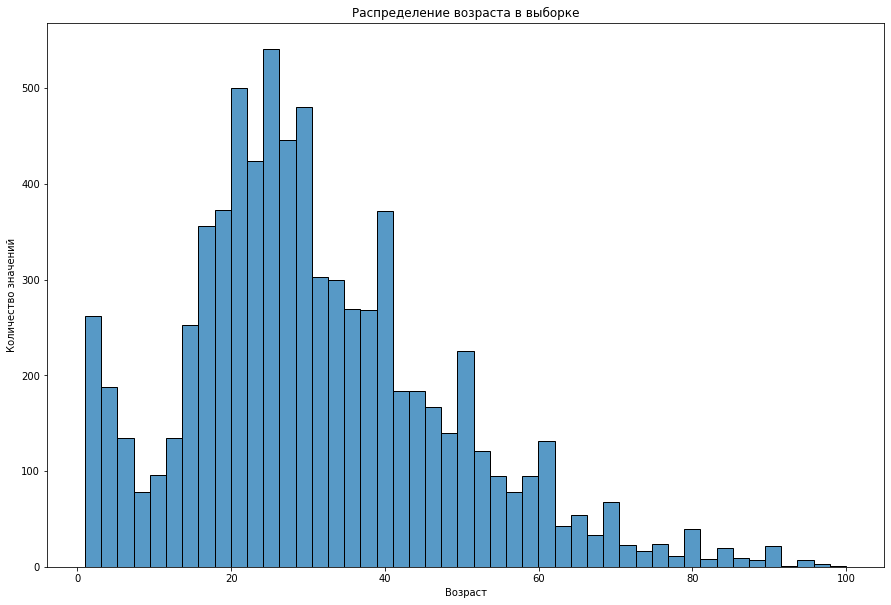

In [4]:
plt.figure(figsize=(15,10))
sns.histplot(data=labels['real_age'])
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество значений')
plt.show()

In [5]:
features, target = next(train_gen_flow)

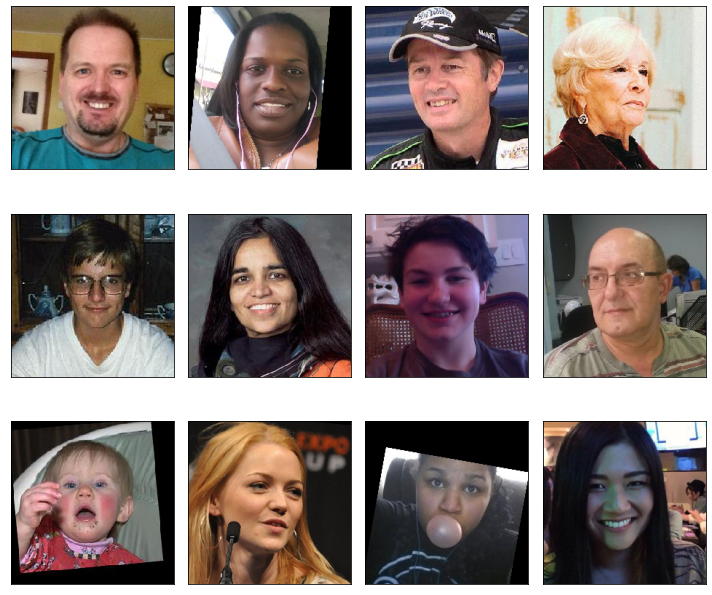

In [6]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<a id='part_1_conclusions'></a>
## Выводы [▴](#head)

- Наш датасет состоит из `7591` фотографий
- Пропусков нет, все данные нужного типа, предобработка не требуется
- Возраст людей в датасете варьируется от `1` до `100` лет
- Средний возраст нашей группы `30` лет
- В датасете не совсем нормальное распределение данных, мы видим явную просадку на возрасте `10` лет. Сложно сказать с чем это связано, но на основе этой просадки можно сделать вывод, что модель будет хуже определять детей в этой возрастной категории так как примеров с нимим меньше. 
- На ровных значениях `30, 40, 50, 60 ...` видны явные всплески по количеству данных возрастов. Это означает, что скорей всего данные размечались людьми, а не брались из какой то базы данных с реальными возрастами, тех кто на фото. Иначе бы мы увидели равномерный купол без всплесков, т.к. людям свойственно приводить все к ровным цифрам `10, 20, 30 ...` Это означает, что результаты оценки возраста нашей моделью будут изначально немного размыты в пределах плюс минус `5-7` лет

- В датасете фотографий замечены следующие особенности:
    - помимо цветных фото встречаются и черно-белые
    - лица на фотографиях расположены в нужной ориентации, разворачивать фото не требуется
    - встречаются фотографии где вместо лица, человек изображен целиком, такие фото будут вносить шум в наши данные, но их количество относительно общей массы корректных фотографий небольшое

<a id='part_2'></a>
# 2. Обучение модели [▴](#head)

<a id='part_2_1'></a>
## 2.1 Код обучения модели [▴](#head)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd

datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
optimizer = Adam(lr=0.0005)


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_data = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_data


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_data = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_data


def create_model(input_shape):
    model = Sequential()
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)     
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    model.summary()
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

<a id='part_2_2'></a>
## 2.2 Результат вывода на экран [▴](#head)

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

Train for 178 steps, validate for 60 steps
Epoch 1/15
2022-11-11 17:51:53.085960: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-11-11 17:51:53.370433: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 48s - loss: 194.9205 - mae: 10.4559 - val_loss: 295.1813 - val_mae: 12.8327
Epoch 2/15
178/178 - 39s - loss: 97.1505 - mae: 7.5027 - val_loss: 476.4618 - val_mae: 16.7212
Epoch 3/15
178/178 - 39s - loss: 62.9590 - mae: 6.0694 - val_loss: 284.6562 - val_mae: 12.6685
Epoch 4/15
178/178 - 39s - loss: 40.9083 - mae: 4.9643 - val_loss: 190.5961 - val_mae: 10.2422
Epoch 5/15
178/178 - 39s - loss: 31.4202 - mae: 4.3142 - val_loss: 125.6025 - val_mae: 8.3463
Epoch 6/15
178/178 - 39s - loss: 23.2183 - mae: 3.7318 - val_loss: 96.0722 - val_mae: 7.4368
Epoch 7/15
178/178 - 39s - loss: 15.2058 - mae: 3.0127 - val_loss: 85.8527 - val_mae: 7.2078
Epoch 8/15
Epoch 9/15
178/178 - 39s - loss: 12.4038 - mae: 2.6787 - val_loss: 91.0641 - val_mae: 6.9563
178/178 - 39s - loss: 11.3097 - mae: 2.5483 - val_loss: 88.2710 - val_mae: 7.3319
Epoch 10/15
178/178 - 39s - loss: 9.7918 - mae: 2.3835 - val_loss: 73.7476 - val_mae: 6.4448
Epoch 11/15
178/178 - 39s - loss: 8.4415 - mae: 2.2312 - val_loss: 71.8539 - val_mae: 6.4284
Epoch 12/15
178/178 - 38s - loss: 7.6962 - mae: 2.0926 - val_loss: 69.6883 - val_mae: 6.3260
Epoch 13/15
Epoch 14/15
178/178 - 39s - loss: 7.4794 - mae: 2.0932 - val_loss: 71.7376 - val_mae: 6.2916
178/178 - 39s - loss: 7.3955 - mae: 2.0657 - val_loss: 70.8265 - val_mae: 6.3474
Epoch 15/15
178/178 - 39s - loss: 7.6591 - mae: 2.1064 - val_loss: 73.3438 - val_mae: 6.5378
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 73.3438 - mae: 6.5378
Test MAE: 6.5378
```

<a id='part_3'></a>
# 3. Анализ обученной модели [▴](#head)

- Нашей модели понадобилось `6` эпох, чтобы выйти на необходимое качество.
- Итоговая средняя абсолютная ошибка составила `6.5` что означает, что модель может промахиваться в среднем на `6.5` лет. Учитывая, что модель будет использоваться для сбора статистики, а не прямого контроля за каким то процессом, без участия человека на этапе принятия решений, такая ошибка вполне приемлема.
- С учетом того, что данные для датасета размечались скорей всего людьми, стоит учитывать? что показания модели и реальный возраст могут отличаться больше чем в среднем на `6.5` лет.

- Для обучения модели мы использовали архитектуру `ResNet50` со следующими параметрами:
    - размер входного изображения: `(224, 224, 3)`
    - предзагруженные веса `weights` взяли с сервера
- Слои расположили в таком порядке:
    - `ResNet50`
    - `GlobalAveragePooling2D` который возвращает среднее значение из группы пикселей внутри канала
    - Полносвязный слой `Dense` для регрессии с `1` нейроном и активацией `Relu`
- Нейронную сеть обучили со следующими параметрами:
    - функция потерь `MSE`
    - алгоритм обучения `Adam` с шагом `0.0005`
    - метрика качества `MAE`

<a id='check_list'></a>
## Чек-лист готовности проекта [▴](#head)

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы